In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata

import matplotlib.cm as cm
import matplotlib.colors as mcolors

#R interface
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

from rpy2.robjects.packages import importr
grdevices = importr('grDevices')

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

import gc

In [2]:
%%R
library('ComplexHeatmap')
library(viridis)
library(proxy)
library(seriation)
library(dendextend)

In [3]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'

In [4]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

Parse study

In [5]:
# Load adata obs and uns
adata=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r')
studies_parsed_map={
 'Fltp_2y':'aged',
 'Fltp_adult':'4m',
 'Fltp_P16':'P16',
 'NOD':'5wNOD',
 'NOD_elimination':'8-16wNOD',
 'spikein_drug':'chem',
 'embryo':'embryonic',
 'VSG':'db/db',
 'STZ':'mSTZ'
}
clustering = 'study' 
adata.obs[clustering+'_parsed']=adata.obs[clustering].map(studies_parsed_map)
sc.pl._utils._set_default_colors_for_categorical_obs(adata, 'study_parsed')
obs=adata.obs.copy()
study_colors=adata.uns['study_parsed_colors']
del adata
gc.collect()

200

In [6]:
obs.study_parsed.unique()

['aged', '4m', 'P16', '5wNOD', '8-16wNOD', 'chem', 'embryonic', 'db/db', 'mSTZ']
Categories (9, object): ['aged', 'P16', '4m', '5wNOD', ..., 'mSTZ', 'db/db', 'embryonic', 'chem']

In [7]:
# Set study order and colors
studies_const_order=['embryo','Fltp_P16','Fltp_adult' ,'Fltp_2y', 
              'spikein_drug', 'NOD', 'NOD_elimination', 'STZ', 'VSG']
studies_order=[obs.query('study==@study')['study_parsed'][0] 
               for study in studies_const_order]
study_cmap=dict(zip(obs.study_parsed.cat.categories,study_colors))

Data for plotting

In [8]:
# Df for plotting
plot_data=pd.DataFrame()

In [9]:
# Sample order for plotting
samples=[]
studies=[]
design_order=['mRFP','mTmG','mGFP',
          'head_Fltp-','tail_Fltp-', 'head_Fltp+', 'tail_Fltp+',
          'IRE1alphafl/fl','IRE1alphabeta-/-', 
          '8w','14w', '16w',
          'DMSO_r1','DMSO_r2', 'DMSO_r3','GABA_r1','GABA_r2', 'GABA_r3',
               'A1_r1','A1_r2','A1_r3','A10_r1','A10_r2', 'A10_r3',  'FOXO_r1', 'FOXO_r2', 'FOXO_r3', 
          'E12.5','E13.5','E14.5', 'E15.5', 
          'chow_WT','sham_Lepr-/-','PF_Lepr-/-','VSG_Lepr-/-',   
          'control','STZ', 'STZ_GLP-1','STZ_estrogen', 'STZ_GLP-1_estrogen',
              'STZ_insulin','STZ_GLP-1_estrogen+insulin' 
        ]
for study in studies_order:
    designs=obs.query('study_parsed ==@study')[['study_sample_design','design']].drop_duplicates()
    designs.design=pd.Categorical(designs.design, 
                  categories=[design for design in design_order if design in list(designs.design.values)],
                  ordered=True)
    designs=designs.sort_values('design')['study_sample_design'].values
    samples.extend(designs)
    # Also save studies for samples
    studies.extend([study]*len(designs))
plot_data.index=samples
plot_data['study']=studies

In [10]:
# Perturbation stress and treatment map
plot_data['stress']=''
plot_data['stress_anno']=''
plot_data['treatment_anno']=''
for sample in plot_data.index:
    if 'STZ' in sample and 'control' not in sample:
        p='T2D'
        a='mSTZ'
        t='+'.join(sample.split('_')[3:])
        # Shorten the name
        t=t.replace('GLP-1','G').replace('estrogen','e').replace('insulin','i')
    elif 'VSG' in sample and 'WT' not in sample:
        p='T2D'
        a='db/db'
        t=sample.split('_')[2]
        # Sham is not a treatment
        t=t if t!='sham' else ''
    elif 'spikein_drug' in sample and 'DMSO' not in sample:
        p='other chemical'
        a=sample.split('_')[3]
        t=''
    elif 'NOD' in sample:
        p='T1D'
        a='NOD'
        t=''
    else:
        p='none'
        a=''
        t=''
    plot_data.at[sample,'stress']=p
    plot_data.at[sample,'stress_anno']=a
    plot_data.at[sample,'treatment_anno']=t
stress_cmap={'T1D':'#D8E6AF','T2D':'#AAC9D2', 'other chemical':'#F9CCEE','none':'#EAEAEA'}
stress_order=['T1D','T2D','other chemical','none']

In [11]:
# Age map
study_parsed_map=dict(zip(obs.study_parsed,obs.study))
study_age_categ={
    'embryo':'E',
    'Fltp_2y':'2y', 
    'Fltp_adult':'3-7m', 
    'Fltp_P16':'0-1m', 
    'NOD':'1-1.5m', 
   # 'NOD_elimination':None, 
    'spikein_drug':'2-3m', 
    'VSG':'3-7m', 
    'STZ':'3-7m'}

# Add special color for embryo
ages_order=['0-1m','1-1.5m','1.5-2m','2-3m','3-7m','2y']
normalize = mcolors.Normalize(vmin=0,  vmax=len(ages_order)-1)
age_cmap={age:mcolors.to_hex(cm.viridis(normalize(idx)),keep_alpha=False) 
          for idx,age in enumerate(ages_order)}
ages_order.insert(0,'E')
age_cmap['E']='#000000'
# Make colors lighetr
age_cmap={a:c+'80' for a,c in age_cmap.items()}
for sample,study in zip(plot_data.index,plot_data.study):
    study=study_parsed_map[study]
    if study=='NOD_elimination':
        if '8w' in sample:
            age='1.5-2m'
        else:
            age='3-7m'
    else:
        age=study_age_categ[study]
    plot_data.at[sample,'age']=age
    plot_data['age_anno']=[obs.query('study_sample_design==@s')['age'][0].replace(' ','') 
                           for s in plot_data.index]

In [12]:
# Sex
sexes_order=['male','female','mixed']
sexes_cmap={'male':'#22A9DA80','female':'#FF575780','mixed':'#CEB54D80'}
plot_data['sex']=''
for sample in plot_data.index:
    sex=obs.query('study_sample_design==@sample').sex.unique()
    if len(sex)>1:
        sex='mixed'
    else:
        sex=sex[0]
    plot_data.at[sample,'sex']=sex

In [13]:
plot_data

,study,stress,stress_anno,treatment_anno,age,age_anno,sex
embryo_E12_5_E12.5,embryonic,none,,,E,12.5E,mixed
embryo_E13_5_E13.5,embryonic,none,,,E,13.5E,mixed
embryo_E14_5_E14.5,embryonic,none,,,E,14.5E,mixed
embryo_E15_5_E15.5,embryonic,none,,,E,15.5E,mixed
Fltp_P16_146_mRFP_mRFP,P16,none,,,0-1m,16d,mixed
Fltp_P16_147_mTmG_mTmG,P16,none,,,0-1m,16d,mixed
Fltp_P16_145_mGFP_mGFP,P16,none,,,0-1m,16d,mixed
Fltp_adult_mouse1_head_Fltp-,4m,none,,,3-7m,4m,male
Fltp_adult_mouse3_tail_Fltp-,4m,none,,,3-7m,4m,male
Fltp_adult_mouse2_head_Fltp+,4m,none,,,3-7m,4m,male


Plot

In [14]:
# Add data to R
ro.globalenv['plot_data']=plot_data
ro.globalenv['studies_order']=studies_order
ro.globalenv['study_colors']=[study_cmap[s] for s in studies_order]
ro.globalenv['stress_order']=stress_order
ro.globalenv['stress_colors']=[stress_cmap[s] for s in stress_order]
ro.globalenv['ages_order']=ages_order
ro.globalenv['age_colors']=[age_cmap[a] for a in ages_order]
ro.globalenv['sexes_order']=sexes_order
ro.globalenv['sexes_colors']=[sexes_cmap[s] for s in sexes_order]
ro.globalenv['na_color']=stress_cmap['none']

In [15]:
%%R
w_cm<-50
h_cm<-1.7

In [16]:
%%R
# Make heatmap list
# Age and study anno
mat=t(plot_data['age'])
mat_anno_age<-t(plot_data['age_anno'])
colnames(mat)<-NULL
rownames(mat)<-'age'
colors=as.list(setNames(age_colors,ages_order))
ha<-HeatmapAnnotation(dataset = anno_block(
    gp = gpar(fill=unlist(study_colors),col=unlist(study_colors),lwd =2,linejoin='mitre'),
          labels = studies_order, labels_gp = gpar(col = 'white'),show_name = TRUE), 
                      annotation_name_side = "left")
h_age<-Heatmap(mat, name = "age", col = colors,row_names_side = "left", 
        cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", mat_anno_age[i, j]), x, y, gp = gpar(fontsize = 12),rot = 90)
        },
        rect_gp = gpar(col = "white", lwd = 1), 
        column_split = factor(plot_data[,'study'],levels=unlist(studies_order)),
       width = unit(w_cm, "cm"), height=unit(h_cm,'cm'),
       top_annotation=ha,column_title=NULL,
              heatmap_legend_param = list(
                  nrow = 1, title = "age:", title_position = "leftcenter",
                     labels_gp = gpar(fontsize = 14),
                         title_gp = gpar(fontface='bold',fontsize = 14)))

# Sex anno
mat=t(plot_data['sex'])
colnames(mat)<-NULL
rownames(mat)<-'sex'
colors=as.list(setNames(sexes_colors,sexes_order))
h_sex<-Heatmap(mat, name = "sex", col = colors,row_names_side = "left", 
        rect_gp = gpar(col = "white", lwd = 1), 
        column_split = factor(plot_data[,'study'],levels=unlist(studies_order)),
        width = unit(w_cm, "cm"), height=unit(h_cm,'cm'),column_title=NULL,
              heatmap_legend_param = list(
                  nrow = 1, title = "     sex:", title_position = "leftcenter",
                     labels_gp = gpar(fontsize = 14),
                         title_gp = gpar(fontface='bold',fontsize = 14)))

# Steress anno
mat=t(plot_data['stress'])
mat_anno_stress<-t(plot_data['stress_anno'])
rownames(mat)<-'stress'
colors=as.list(setNames(stress_colors,stress_order))
h_stress<-Heatmap(mat, name = "stress", col = colors, row_names_side = "left",
       cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", mat_anno_stress[i, j]), x, y, gp = gpar(fontsize = 12),rot = 90)
    }, rect_gp = gpar(col = "white", lwd = 1), 
        column_split = factor(plot_data[,'study'],levels=unlist(studies_order)),
        width = unit(w_cm, "cm"), height=unit(h_cm,'cm'),column_title=NULL,
                 heatmap_legend_param = list( 
                     nrow = 1, title = "     stress:", title_position = "leftcenter",
                     labels_gp = gpar(fontsize = 14),
                         title_gp = gpar(fontface='bold',fontsize = 14)),)

# Teratment anno
mat_anno_treatment<-t(plot_data['treatment_anno'])
mat <- as.data.frame(matrix('none', nrow = 1, ncol = ncol(mat_anno_treatment)))
mat[mat_anno_treatment!='']='anti-diabetic'
colnames(mat)<-NULL
rownames(mat)<-'treatment'
colors=as.list(setNames(c(na_color,'#e0baba'),c('none','anti-diabetic')))
h_treatment<-Heatmap(mat, name = "treatment", col = colors, row_names_side = "left",
       cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", mat_anno_treatment[i, j]), x, y, gp = gpar(fontsize = 12),rot = 90)
    }, rect_gp = gpar(col = "white", lwd = 1), 
        column_split = factor(plot_data[,'study'],levels=unlist(studies_order)),
        width = unit(w_cm, "cm"), height=unit(h_cm,'cm'),
        #show_heatmap_legend=FALSE,
                     heatmap_legend_param = list(
                         nrow = 1, title ="     treatment:", title_position = "leftcenter",
                     labels_gp = gpar(fontsize = 14),
                         title_gp = gpar(fontface='bold',fontsize = 14)),
                     column_title =NULL)

h_list = h_age %v% h_sex %v% h_stress %v% h_treatment


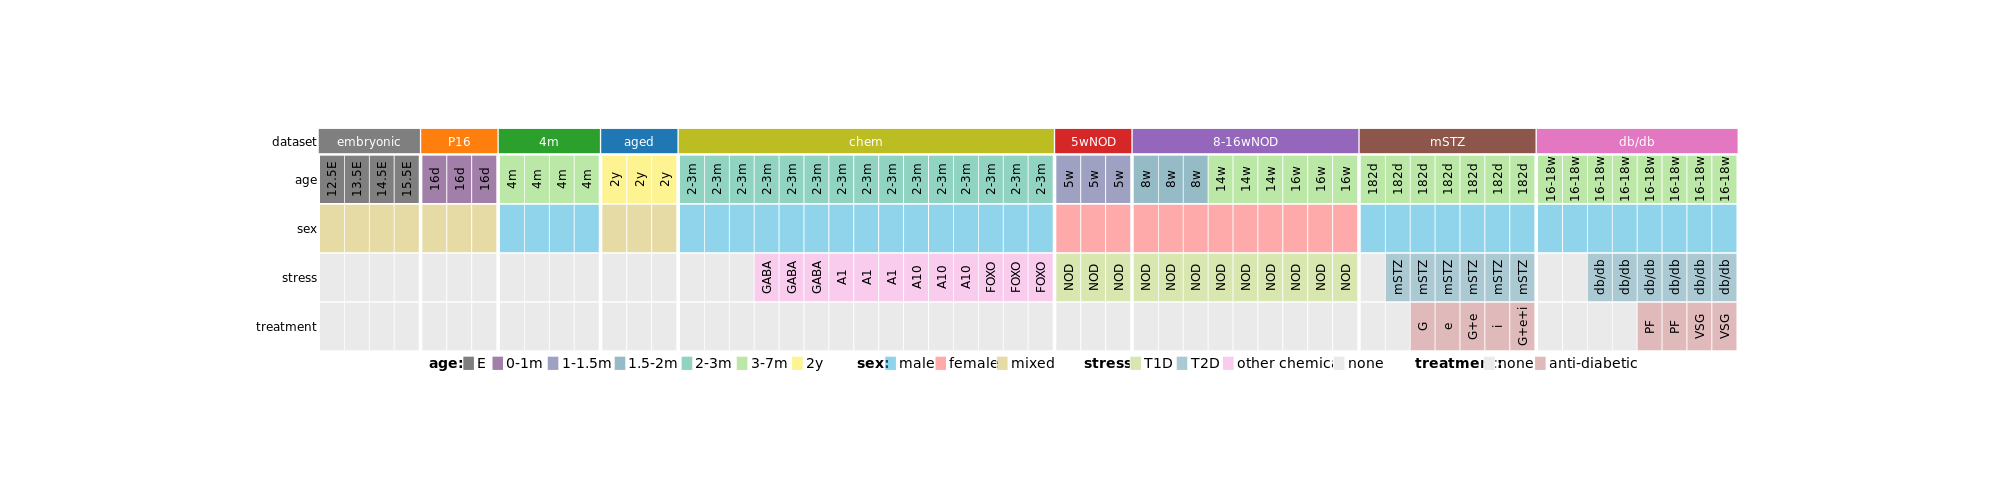

In [17]:
%%R -w 2000 -h 500
# Plot but not save
draw(h_list, ht_gap = unit(0.03, "cm"),heatmap_legend_side = "bottom")

In [18]:
%%R -i path_fig
# Plot and save
png(file=paste0(path_fig,"heatmap_atlas_sampledesign.png"), width=6200, height=1150,res=300)
draw(h_list, ht_gap = unit(0.03, "cm"),heatmap_legend_side = "bottom")
dev.off()

[1] 2


In [27]:
%%R -i path_fig
# Plot and save - for some reason here legend does not overlap
pdf(file=paste0(path_fig,"heatmap_atlas_sampledesign.pdf"), width=20.8, height=3.6)
draw(h_list, ht_gap = unit(0.03, "cm"),heatmap_legend_side = "bottom")
dev.off()

[1] 2


C: For some reason legend elements started overlapping on the new server if saved as png but not as pdf.

In [47]:
%R paste0(path_fig,"heatmap_atlas_sampledesign.png")

array(['/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/heatmap_atlas_sampledesign.png'],
      dtype='<U104')

## Add study order to other saved datasets

In [12]:
for dataset in ['data_integrated_analysed_beta_v1s1.h5ad',
                'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
                'data_integrated_analysed.h5ad']:
    print(dataset)
    # Load adata obs and uns
    adata=sc.read(path_data+dataset)
    adata.obs['study_parsed']=adata.obs['study'].map(studies_parsed_map)
    adata.uns['study_order']=studies_const_order
    adata.uns['study_parsed_order']=studies_order
    adata.uns['study_parsed_colors']=[study_cmap[s] for s in studies_order]
    adata.obs['study_parsed']=pd.Categorical(
        values=adata.obs['study_parsed'],
        categories=adata.uns['study_parsed_order'],ordered=True)
    h.update_adata(
        adata_new=adata, path=path_data+dataset,
        io_copy=False,
        add=[('obs',True,'study_parsed','study_parsed'),
             ('uns',True,'study_order','study_order'),
             ('uns',True,'study_parsed_order','study_parsed_order'),
             ('uns',True,'study_parsed_colors','study_parsed_colors')],
        rm=None)
    del adata

data_integrated_analysed_beta_v1s1.h5ad
data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad
data_integrated_analysed.h5ad
